In [1]:
import os
from os.path import expanduser
home_dir = expanduser("~")
module_path = home_dir + '/modules/'
import sys
sys.path.append(module_path)
fig_dir = 'figures/'
import time
import importlib
import random
import tensorflow as tf
import pandas as pd
from keras.models import Sequential
from keras.layers import Dense
from keras.callbacks import EarlyStopping
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from scipy import stats
import model_management
from scipy.special import comb
import datetime
import codecs, json
from itertools import combinations
%load_ext autoreload
%autoreload 1
%aimport environmental_density
%aimport data_processing
from environmental_density import get_density_periodic
from data_processing import weighted_mse_1, load_galfile, divide_train_data, normalise_data, get_test_score

np.random.seed(999)
random.seed(999)

/opt/anaconda/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


In [ ]:
if run_on_cpu:
    os.environ["CUDA_VISIBLE_DEVICES"] = ""

## Set parameter string

In [ ]:
### Set name ending with parameters for figures to be saved
param_string = 'nLayers_%d_nNeurons_%d_actFun_%s_lossFunc_%s_nTrainSamples_%d_nEpochs_%d_batchSize_%d' % (
    nLayers, neuronsPerLayer, activationFunction, loss_function, train_size, nEpochs, batchSize)
print(param_string)

In [ ]:
print(np.mean(y_test_norm, 0))
print(np.std(y_test_norm, 0))
print(np.min(x_test_norm, 0))
print(np.max(x_test_norm, 0))

In [ ]:
### Get a feel for the data
for i in range(len(input_features)):
    print(input_features[i],': min: %.2e, max: %.2e.' % (np.min(x_train[:,i]), np.max(x_train[:,i])))
for i in range(len(output_features)):
    print(output_features[i],': min: %.2e, max: %.2e.' % (np.min(y_train[:,i]), np.max(y_train[:,i])))

In [2]:
loss_func_dict = {
    'mse': 'mse',
    'mae': 'mae',
    'weighted_mse_1': weighted_mse_1
}

In [ ]:
### Visualisation for when we have 2 input features
%matplotlib notebook
input_feat_1 = 0
input_feat_2 = 1
output_feat = 1

fig = plt.figure(1, figsize=(8,8))
ax = fig.add_subplot(111, projection='3d')
ax.scatter(x_train_norm[:500,input_feat_1], x_train_norm[:500,input_feat_2], 
           y_train_norm[:500,output_feat])
ax.set_xlabel('%s log($M_{H}/M_{S}$)' % (input_features[input_feat_1]))
ax.set_ylabel('%s log($M_{H}/M_{S}$)' % (input_features[input_feat_2]))
ax.set_zlabel('%s log($M_{G}/M_{S}$)' % (output_features[output_feat]))
plt.show()

## Load an existing model

In [ ]:
### Search for the model that you want
importlib.reload(model_management)
search_dict = {
    'training_method': 'backprop'
}
[model_dicts, description_dicts] = model_management.SearchModel(search_dict, get_hits=True)
print(description_dicts)
print('\n')
for key in model_dicts:
    print(key)
    print(model_dicts[key])
    print('\n')


In [ ]:
importlib.reload(model_management)
model, model_dict, description = model_management.LoadModel(search_dict, 1)

## Create a new model

In [44]:
### General parameters
nr_steps = 1e5
batch_size = 2.5e4
total_set_size = 300000 # how many examples will be used for training+validation+testing
train_size = 250000
val_size = 25000
test_size = 25000
norm = 'zero_to_one' # 'none',   'zero_mean_unit',   'zero_to_one'
input_features = ['Halo_mass', 'Halo_mass_peak', 'Scale_peak_mass', 'Scale_half_mass', 'Scale_last_MajM']
output_features = ['Stellar_mass', 'SFR']
early_stop_patience = 200
early_stop_monitor = 'val_loss'
early_stop_min_delta = 1e-8

nr_epochs = nr_steps * batch_size / train_size

### Network parameters
nLayers = 10
activationFunction = 'tanh'
neuronsPerLayer = 30
loss_function = 'mse' # 'mse', 'weighted_mse_1' 'mae'

In [45]:
# load the selected galaxyfile
galaxies, data_keys, unit_dict = load_galfile()
    
# prepare the training data
training_data_dict = divide_train_data(galaxies, data_keys, input_features, output_features, 
                                       total_set_size, train_size, val_size, test_size)
training_data_dict = normalise_data(training_data_dict, norm)

In [54]:
print(data_keys)
print(np.sum(galaxies[:,8] == 0))

{'X_pos': 0, 'Y_pos': 1, 'Z_pos': 2, 'X_vel': 3, 'Y_vel': 4, 'Z_vel': 5, 'Halo_mass': 6, 'Stellar_mass': 7, 'SFR': 8, 'Intra_cluster_mass': 9, 'Halo_mass_peak': 10, 'Stellar_mass_obs': 11, 'SFR_obs': 12, 'Halo_radius': 13, 'Concentration': 14, 'Halo_spin': 15, 'Scale_peak_mass': 16, 'Scale_half_mass': 17, 'Scale_last_MajM': 18, 'Type': 19, 'Environmental_density': 20}
26258


In [47]:
# create model
model = Sequential()
model.add(Dense(neuronsPerLayer, input_dim = len(input_features), activation = activationFunction))

for i in range(0, nLayers-1): # -1 because one layer is added automatically with the input layer
    model.add(Dense(neuronsPerLayer, activation = activationFunction))

model.add(Dense(len(output_features)))#, activation = 'sigmoid'))

# Compile model
earlystop = EarlyStopping(monitor=early_stop_monitor, min_delta=early_stop_min_delta, patience=early_stop_patience, \
                          verbose=1, mode='auto')
callbacks_list = [earlystop]
model.compile(loss=loss_func_dict[loss_function], optimizer='adam')#, metrics=[loss_function])

# Fit the model
if training_data_dict['norm'] == 'none':
    history = model.fit(training_data_dict['x_train'], training_data_dict['y_train'], 
                        validation_data=(training_data_dict['x_val'], training_data_dict['y_val']), 
                        epochs=int(nr_epochs), batch_size=int(batch_size), callbacks=callbacks_list)
else:
    history = model.fit(training_data_dict['x_train_norm'] , training_data_dict['y_train_norm'], 
                        validation_data=(training_data_dict['x_val_norm'], training_data_dict['y_val_norm']), 
                        epochs=int(nr_epochs), batch_size=int(batch_size), callbacks=callbacks_list)

Train on 250000 samples, validate on 25000 samples
Epoch 1/10000
250000/250000 [==============================] - 3s 14us/step - loss: 0.5791 - val_loss: 0.1082
Epoch 2/10000
250000/250000 [==============================] - 0s 1us/step - loss: 0.0534 - val_loss: 0.0334
Epoch 3/10000
250000/250000 [==============================] - 0s 1us/step - loss: 0.0234 - val_loss: 0.0173
Epoch 4/10000
250000/250000 [==============================] - 0s 1us/step - loss: 0.0129 - val_loss: 0.0104
Epoch 5/10000
250000/250000 [==============================] - 0s 1us/step - loss: 0.0084 - val_loss: 0.0067
Epoch 6/10000
250000/250000 [==============================] - 0s 1us/step - loss: 0.0059 - val_loss: 0.0050
Epoch 7/10000
250000/250000 [==============================] - 0s 1us/step - loss: 0.0047 - val_loss: 0.0042
Epoch 8/10000
250000/250000 [==============================] - 0s 1us/step - loss: 0.0042 - val_loss: 0.0038
Epoch 9/10000
250000/250000 [==============================] - 0s 1us/step -

250000/250000 [==============================] - 0s 1us/step - loss: 0.0017 - val_loss: 0.0017
Epoch 76/10000
250000/250000 [==============================] - 0s 1us/step - loss: 0.0017 - val_loss: 0.0017
Epoch 77/10000
250000/250000 [==============================] - 0s 1us/step - loss: 0.0017 - val_loss: 0.0016
Epoch 78/10000
250000/250000 [==============================] - 0s 1us/step - loss: 0.0017 - val_loss: 0.0016
Epoch 79/10000
250000/250000 [==============================] - 0s 1us/step - loss: 0.0017 - val_loss: 0.0016
Epoch 80/10000
250000/250000 [==============================] - 0s 1us/step - loss: 0.0017 - val_loss: 0.0016
Epoch 81/10000
250000/250000 [==============================] - 0s 1us/step - loss: 0.0017 - val_loss: 0.0016
Epoch 82/10000
250000/250000 [==============================] - 0s 1us/step - loss: 0.0017 - val_loss: 0.0016
Epoch 83/10000
250000/250000 [==============================] - 0s 1us/step - loss: 0.0017 - val_loss: 0.0016
Epoch 84/10000
250000/250

250000/250000 [==============================] - 0s 1us/step - loss: 0.0014 - val_loss: 0.0014
Epoch 150/10000
250000/250000 [==============================] - 0s 1us/step - loss: 0.0014 - val_loss: 0.0014
Epoch 151/10000
250000/250000 [==============================] - 0s 1us/step - loss: 0.0014 - val_loss: 0.0013
Epoch 152/10000
250000/250000 [==============================] - 0s 1us/step - loss: 0.0014 - val_loss: 0.0013
Epoch 153/10000
250000/250000 [==============================] - 0s 1us/step - loss: 0.0014 - val_loss: 0.0013
Epoch 154/10000
250000/250000 [==============================] - 0s 1us/step - loss: 0.0014 - val_loss: 0.0013
Epoch 155/10000
250000/250000 [==============================] - 0s 1us/step - loss: 0.0014 - val_loss: 0.0013
Epoch 156/10000
250000/250000 [==============================] - 0s 1us/step - loss: 0.0014 - val_loss: 0.0013
Epoch 157/10000
250000/250000 [==============================] - 0s 1us/step - loss: 0.0014 - val_loss: 0.0013
Epoch 158/10000
2

Epoch 223/10000
250000/250000 [==============================] - 0s 1us/step - loss: 0.0012 - val_loss: 0.0012
Epoch 224/10000
250000/250000 [==============================] - 0s 1us/step - loss: 0.0012 - val_loss: 0.0012
Epoch 225/10000
250000/250000 [==============================] - 0s 1us/step - loss: 0.0012 - val_loss: 0.0012
Epoch 226/10000
250000/250000 [==============================] - 0s 1us/step - loss: 0.0012 - val_loss: 0.0012
Epoch 227/10000
250000/250000 [==============================] - 0s 1us/step - loss: 0.0012 - val_loss: 0.0012
Epoch 228/10000
250000/250000 [==============================] - 0s 1us/step - loss: 0.0012 - val_loss: 0.0012
Epoch 229/10000
250000/250000 [==============================] - 0s 1us/step - loss: 0.0012 - val_loss: 0.0012
Epoch 230/10000
250000/250000 [==============================] - 0s 1us/step - loss: 0.0012 - val_loss: 0.0012
Epoch 231/10000
250000/250000 [==============================] - 0s 1us/step - loss: 0.0012 - val_loss: 0.0012
E

Epoch 297/10000
250000/250000 [==============================] - 0s 1us/step - loss: 0.0011 - val_loss: 0.0010
Epoch 298/10000
250000/250000 [==============================] - 0s 1us/step - loss: 0.0011 - val_loss: 0.0010
Epoch 299/10000
250000/250000 [==============================] - 0s 1us/step - loss: 0.0011 - val_loss: 0.0010
Epoch 300/10000
250000/250000 [==============================] - 0s 1us/step - loss: 0.0011 - val_loss: 0.0010
Epoch 301/10000
250000/250000 [==============================] - 0s 1us/step - loss: 0.0011 - val_loss: 0.0010
Epoch 302/10000
250000/250000 [==============================] - 0s 1us/step - loss: 0.0011 - val_loss: 0.0010
Epoch 303/10000
250000/250000 [==============================] - 0s 1us/step - loss: 0.0011 - val_loss: 0.0010
Epoch 304/10000
250000/250000 [==============================] - 0s 1us/step - loss: 0.0011 - val_loss: 0.0010
Epoch 305/10000
250000/250000 [==============================] - 0s 1us/step - loss: 0.0011 - val_loss: 0.0010
E

250000/250000 [==============================] - 0s 1us/step - loss: 9.9888e-04 - val_loss: 9.6989e-04
Epoch 370/10000
250000/250000 [==============================] - 0s 1us/step - loss: 9.9816e-04 - val_loss: 9.6941e-04
Epoch 371/10000
250000/250000 [==============================] - 0s 1us/step - loss: 9.9735e-04 - val_loss: 9.6846e-04
Epoch 372/10000
250000/250000 [==============================] - 0s 1us/step - loss: 9.9654e-04 - val_loss: 9.6750e-04
Epoch 373/10000
250000/250000 [==============================] - 0s 1us/step - loss: 9.9578e-04 - val_loss: 9.6703e-04
Epoch 374/10000
250000/250000 [==============================] - 0s 1us/step - loss: 9.9516e-04 - val_loss: 9.6607e-04
Epoch 375/10000
250000/250000 [==============================] - 0s 1us/step - loss: 9.9435e-04 - val_loss: 9.6512e-04
Epoch 376/10000
250000/250000 [==============================] - 0s 1us/step - loss: 9.9373e-04 - val_loss: 9.6464e-04
Epoch 377/10000
250000/250000 [==============================] -

Epoch 438/10000
250000/250000 [==============================] - 0s 1us/step - loss: 9.5205e-04 - val_loss: 9.2602e-04
Epoch 439/10000
250000/250000 [==============================] - 0s 1us/step - loss: 9.5210e-04 - val_loss: 9.2602e-04
Epoch 440/10000
250000/250000 [==============================] - 0s 1us/step - loss: 9.5196e-04 - val_loss: 9.2554e-04
Epoch 441/10000
250000/250000 [==============================] - 0s 1us/step - loss: 9.5177e-04 - val_loss: 9.2459e-04
Epoch 442/10000
250000/250000 [==============================] - 0s 1us/step - loss: 9.5158e-04 - val_loss: 9.2506e-04
Epoch 443/10000
250000/250000 [==============================] - 0s 1us/step - loss: 9.5124e-04 - val_loss: 9.2316e-04
Epoch 444/10000
250000/250000 [==============================] - 0s 1us/step - loss: 9.4991e-04 - val_loss: 9.2363e-04
Epoch 445/10000
250000/250000 [==============================] - 0s 1us/step - loss: 9.4943e-04 - val_loss: 9.2268e-04
Epoch 446/10000
250000/250000 [=================

Epoch 507/10000
250000/250000 [==============================] - 0s 1us/step - loss: 9.3017e-04 - val_loss: 9.0408e-04
Epoch 508/10000
250000/250000 [==============================] - 0s 1us/step - loss: 9.2983e-04 - val_loss: 9.0361e-04
Epoch 509/10000
250000/250000 [==============================] - 0s 1us/step - loss: 9.2978e-04 - val_loss: 9.0313e-04
Epoch 510/10000
250000/250000 [==============================] - 0s 1us/step - loss: 9.2950e-04 - val_loss: 9.0218e-04
Epoch 511/10000
250000/250000 [==============================] - 0s 1us/step - loss: 9.2926e-04 - val_loss: 9.0265e-04
Epoch 512/10000
250000/250000 [==============================] - 0s 1us/step - loss: 9.2883e-04 - val_loss: 9.0218e-04
Epoch 513/10000
250000/250000 [==============================] - 0s 1us/step - loss: 9.2878e-04 - val_loss: 9.0218e-04
Epoch 514/10000
250000/250000 [==============================] - 0s 1us/step - loss: 9.2893e-04 - val_loss: 9.0122e-04
Epoch 515/10000
250000/250000 [=================

Epoch 576/10000
250000/250000 [==============================] - 0s 1us/step - loss: 9.0923e-04 - val_loss: 8.8310e-04
Epoch 577/10000
250000/250000 [==============================] - 0s 1us/step - loss: 9.0952e-04 - val_loss: 8.8310e-04
Epoch 578/10000
250000/250000 [==============================] - 0s 1us/step - loss: 9.0885e-04 - val_loss: 8.8310e-04
Epoch 579/10000
250000/250000 [==============================] - 0s 1us/step - loss: 9.0818e-04 - val_loss: 8.8215e-04
Epoch 580/10000
250000/250000 [==============================] - 0s 1us/step - loss: 9.0747e-04 - val_loss: 8.8215e-04
Epoch 581/10000
250000/250000 [==============================] - 0s 1us/step - loss: 9.0723e-04 - val_loss: 8.8120e-04
Epoch 582/10000
250000/250000 [==============================] - 0s 1us/step - loss: 9.0714e-04 - val_loss: 8.8167e-04
Epoch 583/10000
250000/250000 [==============================] - 0s 1us/step - loss: 9.0714e-04 - val_loss: 8.8120e-04
Epoch 584/10000
250000/250000 [=================

Epoch 645/10000
250000/250000 [==============================] - 0s 1us/step - loss: 8.9130e-04 - val_loss: 8.6927e-04
Epoch 646/10000
250000/250000 [==============================] - 0s 1us/step - loss: 8.9407e-04 - val_loss: 8.7214e-04
Epoch 647/10000
250000/250000 [==============================] - 0s 1us/step - loss: 8.9579e-04 - val_loss: 8.6498e-04
Epoch 648/10000
250000/250000 [==============================] - 0s 1us/step - loss: 8.9197e-04 - val_loss: 8.6403e-04
Epoch 649/10000
250000/250000 [==============================] - 0s 1us/step - loss: 8.8892e-04 - val_loss: 8.6403e-04
Epoch 650/10000
250000/250000 [==============================] - 0s 1us/step - loss: 8.8849e-04 - val_loss: 8.6355e-04
Epoch 651/10000
250000/250000 [==============================] - 0s 1us/step - loss: 8.8882e-04 - val_loss: 8.6451e-04
Epoch 652/10000
250000/250000 [==============================] - 0s 1us/step - loss: 8.8863e-04 - val_loss: 8.6403e-04
Epoch 653/10000
250000/250000 [=================

Epoch 714/10000
250000/250000 [==============================] - 0s 1us/step - loss: 8.6684e-04 - val_loss: 8.4352e-04
Epoch 715/10000
250000/250000 [==============================] - 0s 1us/step - loss: 8.6679e-04 - val_loss: 8.4305e-04
Epoch 716/10000
250000/250000 [==============================] - 0s 1us/step - loss: 8.6937e-04 - val_loss: 8.4496e-04
Epoch 717/10000
250000/250000 [==============================] - 0s 1us/step - loss: 8.6913e-04 - val_loss: 8.4352e-04
Epoch 718/10000
250000/250000 [==============================] - 0s 1us/step - loss: 8.6579e-04 - val_loss: 8.4257e-04
Epoch 719/10000
250000/250000 [==============================] - 0s 1us/step - loss: 8.6579e-04 - val_loss: 8.4257e-04
Epoch 720/10000
250000/250000 [==============================] - 0s 1us/step - loss: 8.6565e-04 - val_loss: 8.4257e-04
Epoch 721/10000
250000/250000 [==============================] - 0s 1us/step - loss: 8.6613e-04 - val_loss: 8.4209e-04
Epoch 722/10000
250000/250000 [=================

Epoch 783/10000
250000/250000 [==============================] - 0s 1us/step - loss: 8.5664e-04 - val_loss: 8.3256e-04
Epoch 784/10000
250000/250000 [==============================] - 0s 1us/step - loss: 8.5669e-04 - val_loss: 8.3208e-04
Epoch 785/10000
250000/250000 [==============================] - 0s 1us/step - loss: 8.5444e-04 - val_loss: 8.3160e-04
Epoch 786/10000
250000/250000 [==============================] - 0s 1us/step - loss: 8.5402e-04 - val_loss: 8.3065e-04
Epoch 787/10000
250000/250000 [==============================] - 0s 1us/step - loss: 8.5354e-04 - val_loss: 8.3017e-04
Epoch 788/10000
250000/250000 [==============================] - 0s 1us/step - loss: 8.5320e-04 - val_loss: 8.3065e-04
Epoch 789/10000
250000/250000 [==============================] - 0s 1us/step - loss: 8.5335e-04 - val_loss: 8.3113e-04
Epoch 790/10000
250000/250000 [==============================] - 0s 1us/step - loss: 8.5330e-04 - val_loss: 8.2970e-04
Epoch 791/10000
250000/250000 [=================

Epoch 852/10000
250000/250000 [==============================] - 0s 1us/step - loss: 8.4209e-04 - val_loss: 8.2016e-04
Epoch 853/10000
250000/250000 [==============================] - 0s 1us/step - loss: 8.4219e-04 - val_loss: 8.2064e-04
Epoch 854/10000
250000/250000 [==============================] - 0s 1us/step - loss: 8.4219e-04 - val_loss: 8.2016e-04
Epoch 855/10000
250000/250000 [==============================] - 0s 1us/step - loss: 8.4214e-04 - val_loss: 8.2064e-04
Epoch 856/10000
250000/250000 [==============================] - 0s 1us/step - loss: 8.4186e-04 - val_loss: 8.1968e-04
Epoch 857/10000
250000/250000 [==============================] - 0s 1us/step - loss: 8.4195e-04 - val_loss: 8.1968e-04
Epoch 858/10000
250000/250000 [==============================] - 0s 1us/step - loss: 8.4200e-04 - val_loss: 8.2016e-04
Epoch 859/10000
250000/250000 [==============================] - 0s 1us/step - loss: 8.4453e-04 - val_loss: 8.1921e-04
Epoch 860/10000
250000/250000 [=================

Epoch 921/10000
250000/250000 [==============================] - 0s 1us/step - loss: 8.3113e-04 - val_loss: 8.0919e-04
Epoch 922/10000
250000/250000 [==============================] - 0s 1us/step - loss: 8.3108e-04 - val_loss: 8.0919e-04
Epoch 923/10000
250000/250000 [==============================] - 0s 1us/step - loss: 8.3051e-04 - val_loss: 8.0919e-04
Epoch 924/10000
250000/250000 [==============================] - 0s 1us/step - loss: 8.3027e-04 - val_loss: 8.0824e-04
Epoch 925/10000
250000/250000 [==============================] - 0s 1us/step - loss: 8.2984e-04 - val_loss: 8.0872e-04
Epoch 926/10000
250000/250000 [==============================] - 0s 1us/step - loss: 8.3003e-04 - val_loss: 8.0919e-04
Epoch 927/10000
250000/250000 [==============================] - 0s 1us/step - loss: 8.3013e-04 - val_loss: 8.0872e-04
Epoch 928/10000
250000/250000 [==============================] - 0s 1us/step - loss: 8.2989e-04 - val_loss: 8.0919e-04
Epoch 929/10000
250000/250000 [=================

Epoch 990/10000
250000/250000 [==============================] - 0s 1us/step - loss: 8.1172e-04 - val_loss: 7.9203e-04
Epoch 991/10000
250000/250000 [==============================] - 0s 1us/step - loss: 8.1162e-04 - val_loss: 7.9155e-04
Epoch 992/10000
250000/250000 [==============================] - 0s 1us/step - loss: 8.1191e-04 - val_loss: 7.9155e-04
Epoch 993/10000
250000/250000 [==============================] - 0s 1us/step - loss: 8.1143e-04 - val_loss: 7.9155e-04
Epoch 994/10000
250000/250000 [==============================] - 0s 1us/step - loss: 8.1100e-04 - val_loss: 7.9107e-04
Epoch 995/10000
250000/250000 [==============================] - 0s 1us/step - loss: 8.1129e-04 - val_loss: 7.9155e-04
Epoch 996/10000
250000/250000 [==============================] - 0s 1us/step - loss: 8.1105e-04 - val_loss: 7.9107e-04
Epoch 997/10000
250000/250000 [==============================] - 0s 1us/step - loss: 8.1081e-04 - val_loss: 7.9060e-04
Epoch 998/10000
250000/250000 [=================

250000/250000 [==============================] - 0s 1us/step - loss: 8.0442e-04 - val_loss: 7.8344e-04
Epoch 1059/10000
250000/250000 [==============================] - 0s 1us/step - loss: 8.0190e-04 - val_loss: 7.7724e-04
Epoch 1060/10000
250000/250000 [==============================] - 0s 1us/step - loss: 7.9579e-04 - val_loss: 7.7724e-04
Epoch 1061/10000
250000/250000 [==============================] - 0s 1us/step - loss: 7.9622e-04 - val_loss: 7.7724e-04
Epoch 1062/10000
250000/250000 [==============================] - 0s 1us/step - loss: 7.9622e-04 - val_loss: 7.7724e-04
Epoch 1063/10000
250000/250000 [==============================] - 0s 1us/step - loss: 7.9613e-04 - val_loss: 7.7772e-04
Epoch 1064/10000
250000/250000 [==============================] - 0s 1us/step - loss: 7.9603e-04 - val_loss: 7.7772e-04
Epoch 1065/10000
250000/250000 [==============================] - 0s 1us/step - loss: 7.9594e-04 - val_loss: 7.7772e-04
Epoch 1066/10000
250000/250000 [=========================

250000/250000 [==============================] - 0s 1us/step - loss: 7.8855e-04 - val_loss: 7.7057e-04
Epoch 1127/10000
250000/250000 [==============================] - 0s 1us/step - loss: 7.8864e-04 - val_loss: 7.7200e-04
Epoch 1128/10000
250000/250000 [==============================] - 0s 1us/step - loss: 7.9317e-04 - val_loss: 7.7248e-04
Epoch 1129/10000
250000/250000 [==============================] - 0s 1us/step - loss: 7.9036e-04 - val_loss: 7.8201e-04
Epoch 1130/10000
250000/250000 [==============================] - 0s 1us/step - loss: 7.9198e-04 - val_loss: 7.9393e-04
Epoch 1131/10000
250000/250000 [==============================] - 0s 1us/step - loss: 8.0104e-04 - val_loss: 7.7581e-04
Epoch 1132/10000
250000/250000 [==============================] - 0s 1us/step - loss: 8.0571e-04 - val_loss: 7.8058e-04
Epoch 1133/10000
250000/250000 [==============================] - 0s 1us/step - loss: 7.9021e-04 - val_loss: 7.7009e-04
Epoch 1134/10000
250000/250000 [=========================

250000/250000 [==============================] - 0s 1us/step - loss: 7.7262e-04 - val_loss: 7.5579e-04
Epoch 1195/10000
250000/250000 [==============================] - 0s 1us/step - loss: 7.7257e-04 - val_loss: 7.5626e-04
Epoch 1196/10000
250000/250000 [==============================] - 0s 1us/step - loss: 7.7257e-04 - val_loss: 7.5579e-04
Epoch 1197/10000
250000/250000 [==============================] - 0s 1us/step - loss: 7.7214e-04 - val_loss: 7.5579e-04
Epoch 1198/10000
250000/250000 [==============================] - 0s 1us/step - loss: 7.7214e-04 - val_loss: 7.5579e-04
Epoch 1199/10000
250000/250000 [==============================] - 0s 1us/step - loss: 7.7195e-04 - val_loss: 7.5579e-04
Epoch 1200/10000
250000/250000 [==============================] - 0s 1us/step - loss: 7.7190e-04 - val_loss: 7.5579e-04
Epoch 1201/10000
250000/250000 [==============================] - 0s 1us/step - loss: 7.7162e-04 - val_loss: 7.5531e-04
Epoch 1202/10000
250000/250000 [=========================

250000/250000 [==============================] - 0s 1us/step - loss: 7.6241e-04 - val_loss: 7.4720e-04
Epoch 1263/10000
250000/250000 [==============================] - 0s 1us/step - loss: 7.6251e-04 - val_loss: 7.4720e-04
Epoch 1264/10000
250000/250000 [==============================] - 0s 1us/step - loss: 7.6590e-04 - val_loss: 7.4911e-04
Epoch 1265/10000
250000/250000 [==============================] - 0s 1us/step - loss: 7.6818e-04 - val_loss: 7.4768e-04
Epoch 1266/10000
250000/250000 [==============================] - 0s 1us/step - loss: 7.6799e-04 - val_loss: 7.5817e-04
Epoch 1267/10000
250000/250000 [==============================] - 0s 1us/step - loss: 7.6838e-04 - val_loss: 7.6580e-04
Epoch 1268/10000
250000/250000 [==============================] - 0s 1us/step - loss: 7.6556e-04 - val_loss: 7.4720e-04
Epoch 1269/10000
250000/250000 [==============================] - 0s 1us/step - loss: 7.6151e-04 - val_loss: 7.4530e-04
Epoch 1270/10000
250000/250000 [=========================

250000/250000 [==============================] - 0s 1us/step - loss: 7.5650e-04 - val_loss: 7.4196e-04
Epoch 1331/10000
250000/250000 [==============================] - 0s 1us/step - loss: 7.5650e-04 - val_loss: 7.4053e-04
Epoch 1332/10000
250000/250000 [==============================] - 0s 1us/step - loss: 7.5626e-04 - val_loss: 7.4100e-04
Epoch 1333/10000
250000/250000 [==============================] - 0s 1us/step - loss: 7.5617e-04 - val_loss: 7.4100e-04
Epoch 1334/10000
250000/250000 [==============================] - 0s 1us/step - loss: 7.5593e-04 - val_loss: 7.4053e-04
Epoch 1335/10000
250000/250000 [==============================] - 0s 1us/step - loss: 7.5593e-04 - val_loss: 7.4100e-04
Epoch 1336/10000
250000/250000 [==============================] - 0s 1us/step - loss: 7.5645e-04 - val_loss: 7.4053e-04
Epoch 1337/10000
250000/250000 [==============================] - 0s 1us/step - loss: 7.5631e-04 - val_loss: 7.4100e-04
Epoch 1338/10000
250000/250000 [=========================

250000/250000 [==============================] - 0s 1us/step - loss: 0.0010 - val_loss: 0.0010
Epoch 1402/10000
250000/250000 [==============================] - 0s 1us/step - loss: 0.0010 - val_loss: 0.0010
Epoch 1403/10000
250000/250000 [==============================] - 0s 1us/step - loss: 0.0010 - val_loss: 0.0010
Epoch 1404/10000
250000/250000 [==============================] - 0s 1us/step - loss: 0.0010 - val_loss: 0.0010
Epoch 1405/10000
250000/250000 [==============================] - 0s 1us/step - loss: 0.0010 - val_loss: 9.9945e-04
Epoch 1406/10000
250000/250000 [==============================] - 0s 1us/step - loss: 0.0010 - val_loss: 9.9659e-04
Epoch 1407/10000
250000/250000 [==============================] - 0s 1us/step - loss: 0.0010 - val_loss: 9.9373e-04
Epoch 1408/10000
250000/250000 [==============================] - 0s 1us/step - loss: 0.0010 - val_loss: 9.8991e-04
Epoch 1409/10000
250000/250000 [==============================] - 0s 1us/step - loss: 9.9850e-04 - val_lo

Epoch 1470/10000
250000/250000 [==============================] - 0s 1us/step - loss: 9.0508e-04 - val_loss: 8.9407e-04
Epoch 1471/10000
250000/250000 [==============================] - 0s 1us/step - loss: 9.0418e-04 - val_loss: 8.9312e-04
Epoch 1472/10000
250000/250000 [==============================] - 0s 1us/step - loss: 9.0370e-04 - val_loss: 8.9264e-04
Epoch 1473/10000
250000/250000 [==============================] - 0s 1us/step - loss: 9.0294e-04 - val_loss: 8.9216e-04
Epoch 1474/10000
250000/250000 [==============================] - 0s 1us/step - loss: 9.0232e-04 - val_loss: 8.9121e-04
Epoch 1475/10000
250000/250000 [==============================] - 0s 1us/step - loss: 9.0151e-04 - val_loss: 8.9025e-04
Epoch 1476/10000
250000/250000 [==============================] - 0s 1us/step - loss: 9.0094e-04 - val_loss: 8.8930e-04
Epoch 1477/10000
250000/250000 [==============================] - 0s 1us/step - loss: 9.0003e-04 - val_loss: 8.8835e-04
Epoch 1478/10000
250000/250000 [========

250000/250000 [==============================] - 0s 1us/step - loss: 8.6336e-04 - val_loss: 8.5306e-04
Epoch 1539/10000
250000/250000 [==============================] - 0s 1us/step - loss: 8.6303e-04 - val_loss: 8.5211e-04
Epoch 1540/10000
250000/250000 [==============================] - 0s 1us/step - loss: 8.6269e-04 - val_loss: 8.5211e-04
Epoch 1541/10000
250000/250000 [==============================] - 0s 1us/step - loss: 8.6217e-04 - val_loss: 8.5163e-04
Epoch 1542/10000
250000/250000 [==============================] - 0s 1us/step - loss: 8.6179e-04 - val_loss: 8.5163e-04
Epoch 1543/10000
250000/250000 [==============================] - 0s 1us/step - loss: 8.6122e-04 - val_loss: 8.5068e-04
Epoch 1544/10000
250000/250000 [==============================] - 0s 1us/step - loss: 8.6079e-04 - val_loss: 8.5068e-04
Epoch 1545/10000
250000/250000 [==============================] - 0s 1us/step - loss: 8.6026e-04 - val_loss: 8.4925e-04
Epoch 1546/10000
250000/250000 [=========================

#### Plot loss history

In [48]:
# list all data in history
print(history.history.keys())

dict_keys(['val_loss', 'loss'])


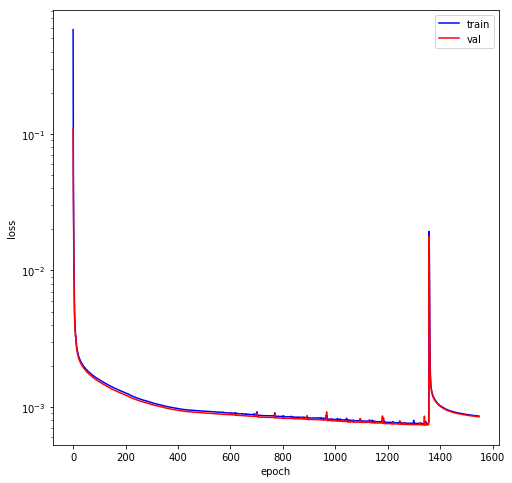

In [49]:
# summarize history for loss
%matplotlib inline
fig = plt.figure(5, figsize=(8,8))
plt.plot(history.history['loss'], 'b')
plt.plot(history.history['val_loss'], 'r')
plt.yscale('log')
#plt.title(title)
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper right')
plt.show()

## Batch runs

#### Do a batch run to see which input parameters gives the best score

In [20]:
total_set_size = 300000
train_size = 250000
val_size = 25000
test_size = 25000

core_input_features = ['Halo_mass', 'Halo_mass_peak', 'Scale_peak_mass']
tested_input_features = ['Concentration', 'Type', 'Scale_half_mass', 
                 'Scale_last_MajM', 'Environmental_density']
output_features = ['Stellar_mass', 'SFR']
nr_extra_params_list = [2]
nr_runs_per_comb = 3

nLayers = 10
activationFunction = 'tanh'
neuronsPerLayer = 30
loss_function = 'mse' # 'mse', 'weighted_mse_1' 'mae'
norm = 'zero_to_one' # 'none',   'zero_mean_unit',   'zero_to_one'

nr_steps = 1e4
batch_size = 4e4

verb = 0 # prints progress to stdout

nr_epochs = nr_steps * batch_size / train_size
parameter_dictionary = {
    'fixed_input_features': core_input_features,
    'tested_input_features': tested_input_features,
    'output_features': output_features,
    'nr_extra_parameter_combinations': nr_extra_params_list,
    'nr_steps': [nr_steps],
    'batch_size': [batch_size],
    'nr_epochs': [nr_epochs],
    'nr_training_samples': [train_size],
    'nr_validation_samples': [val_size],
    'nr_test_samples': [test_size],
    'data_normalization': norm,
    'activation_function': activationFunction,
    'neurons_per_layer': [neuronsPerLayer],
    'nr_hidden_layers': [nLayers],
    'output_activation_function': 'none',
    'description': 'Each parameter setting is represented by one list containing three objects. The first one is ' + \
    'the input parameters. The second one is the mse test scores obtained for the different runs evaluated on the ' +\
    'normed units and the original units of the data set (original only if norm is \'none\'). The third one is the ' +\
    'loss histories for the different runs [training_loss, validation_loss] evaluated on the normalised data.'
}
results_list = [parameter_dictionary]
nr_combs_total = 0
for nr_extra_params in nr_extra_params_list:
    nr_combs_total += comb(len(tested_input_features), nr_extra_params)
comb_counter = 0 # to keep track of how many combinations I've gone through

with open('model_comparisons/progress.txt', 'w+') as f:
    
    date_string_proper = datetime.datetime.now().strftime("%H:%M, %Y-%m-%d")
    f.write('Benchmark done on input parameters at ' + date_string_proper + '\n\n')
    f.flush()
    
    # load the selected galaxyfile
    galaxies, data_keys, unit_dict = load_galfile()
    
    for i_nr_extra_params, nr_extra_params in enumerate(nr_extra_params_list):
        
        extra_param_combs = list(combinations(tested_input_features, nr_extra_params))
        
        date_string_proper = datetime.datetime.now().strftime("%H:%M, %Y-%m-%d")
        f.write(date_string_proper + '    Testing %d extra parameters. %d/%d extra parameter count tested. \n\n' %
                (nr_extra_params, i_nr_extra_params+1, len(nr_extra_params_list)))
        f.flush()
    
        for i_comb, param_comb in enumerate(extra_param_combs):
            input_features = core_input_features.copy()
            input_features.extend(param_comb)
            
            # prepare the training data
            training_data_dict = divide_train_data(galaxies, data_keys, input_features, output_features, 
                                                   total_set_size, train_size, val_size, test_size)
            training_data_dict = normalise_data(training_data_dict, norm)
            
            date_string_proper = datetime.datetime.now().strftime("%H:%M, %Y-%m-%d")
            comb_counter += 1
            f.write(date_string_proper + '        Testing combination %d/%d. \n\n' % (comb_counter, nr_combs_total))
            f.flush()
            
            original_scores = []
            if not norm == 'none':
                normed_scores = []
            histories = []

            for i_run in range(nr_runs_per_comb):

                # create model
                model = Sequential()
                model.add(Dense(neuronsPerLayer, input_dim = len(input_features), activation = activationFunction))

                for i in range(0, nLayers-1): # -1 because one layer is added automatically with the input layer
                    model.add(Dense(neuronsPerLayer, activation = activationFunction))

                model.add(Dense(len(output_features)))

                # Compile model
                earlystop = EarlyStopping(monitor='val_loss', min_delta=1e-7, patience=100, \
                          verbose=1, mode='auto')
                callbacks_list = [earlystop]
                model.compile(loss=loss_func_dict[loss_function], optimizer='adam')

                # Fit the model
                if norm == 'none':
                    history = model.fit(training_data_dict['x_train'], training_data_dict['y_train'], 
                                        validation_data=(training_data_dict['x_val'], training_data_dict['y_val']), 
                                        epochs=int(nr_epochs), batch_size=int(batch_size), callbacks=callbacks_list, 
                                        verbose=verb)
                    orig_score = model.evaluate(x=training_data_dict['x_test'], y=training_data_dict['y_test'],
                                               verbose=verb)
                    original_scores.append(orig_score)
                    
                else:
                    history = model.fit(training_data_dict['x_train_norm'] , training_data_dict['y_train_norm'], 
                                        validation_data=(training_data_dict['x_val_norm'], 
                                        training_data_dict['y_val_norm']), 
                                        epochs=int(nr_epochs), batch_size=int(batch_size), callbacks=callbacks_list, 
                                        verbose=verb)
                    norm_score = model.evaluate(x=training_data_dict['x_test_norm'], y=training_data_dict['y_test_norm'],
                                               verbose=verb)
                    normed_scores.append(norm_score)
                    orig_score = get_test_score(model, training_data_dict, norm)
                    original_scores.append(orig_score)
                    
                histories.append([history.history['loss'], history.history['val_loss']])
                
            if norm == 'none':
                scores = original_scores
            else:
                scores = [normed_scores, original_scores]
                
            results_list.append([input_features, scores, histories])
            
    date_string_proper = datetime.datetime.now().strftime("%H:%M, %Y-%m-%d")
    f.write('Benchmark completed at ' + date_string_proper + '\n')
    f.flush()
        

Epoch 00767: early stopping
Epoch 01390: early stopping
Epoch 01127: early stopping
Epoch 00654: early stopping
Epoch 00865: early stopping
Epoch 01586: early stopping
Epoch 00748: early stopping
Epoch 00765: early stopping
Epoch 01468: early stopping
Epoch 00794: early stopping
Epoch 00691: early stopping
Epoch 01097: early stopping


#### Save the result

In [21]:
### Save the result
date_string = datetime.datetime.now().strftime('%Y-%m-%d--%H-%M-%S')
custom_string = '5_total_inputs'
with open('model_comparisons/' + custom_string + '.json', 'w+') as f:
    json.dump(results_list, f)
f.close()

In [ ]:

#print(train_loss)
print('Lowest train/val/test loss: %.2f, %.2f, %.2f' % (np.amin(train_loss), np.amin(val_loss), np.amin(test_loss)))

#### Load a batch run result

In [22]:
### Load a result
loaded_list_string = '5_total_inputs'
with open('model_comparisons/' + loaded_list_string + '.json', 'r') as f:
    results_list = json.load(f)
f.close()

print(results_list[0])

{'fixed_input_features': ['Halo_mass', 'Halo_mass_peak', 'Scale_peak_mass'], 'tested_input_features': ['Concentration', 'Type', 'Scale_half_mass', 'Scale_last_MajM', 'Environmental_density'], 'output_features': ['Stellar_mass', 'SFR'], 'nr_extra_parameter_combinations': [2], 'nr_steps': [10000.0], 'batch_size': [40000.0], 'nr_epochs': [1600.0], 'nr_training_samples': [250000], 'nr_validation_samples': [25000], 'nr_test_samples': [25000], 'data_normalization': 'zero_to_one', 'activation_function': 'tanh', 'neurons_per_layer': [30], 'nr_hidden_layers': [10], 'output_activation_function': 'none', 'description': "Each parameter setting is represented by one list containing three objects. The first one is the input parameters. The second one is the mse test scores obtained for the different runs evaluated on the normed units and the original units of the data set (original only if norm is 'none'). The third one is the loss histories for the different runs [training_loss, validation_loss] ev

#### Plot the results

In [5]:
print(len(results_list[1][1]))
print(results_list[1][1])

2
[[0.001323441162109375, 0.00152518310546875, 0.0021285626220703124], [0.22563490693878274, 0.2635417926546065, 0.24976286216501617]]


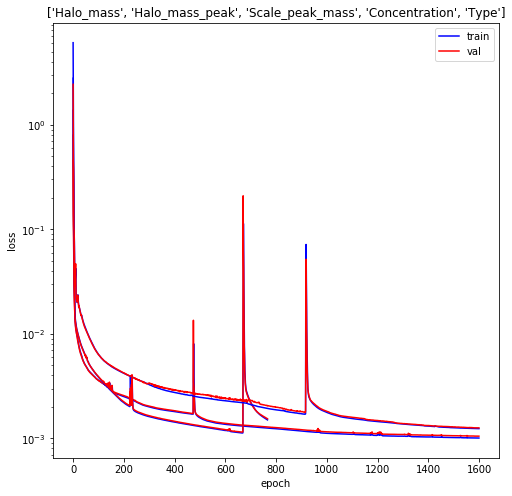

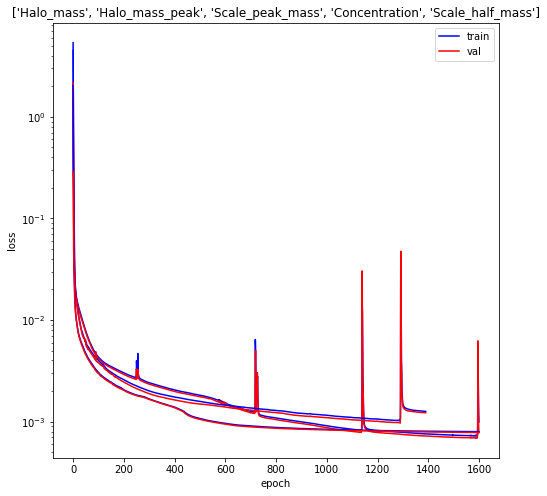

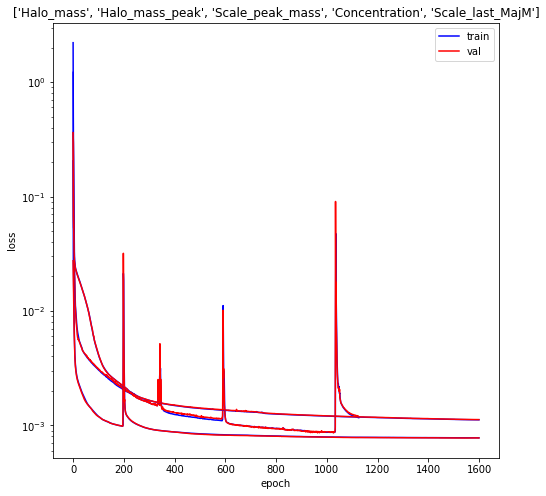

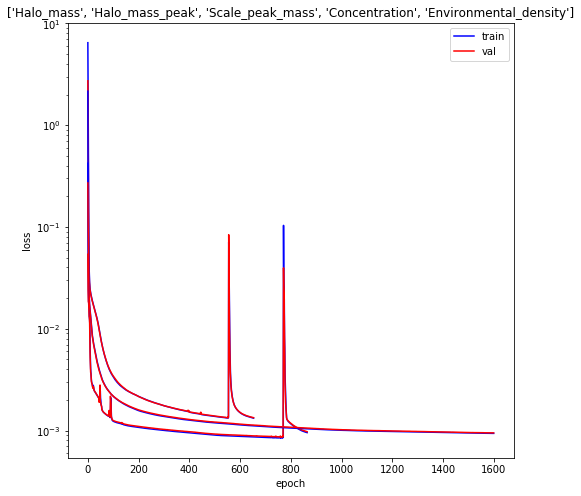

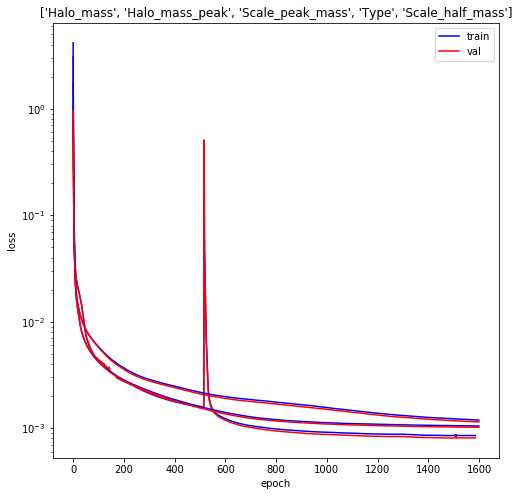

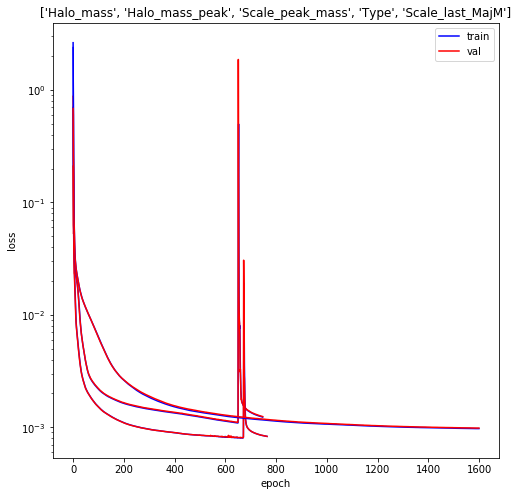

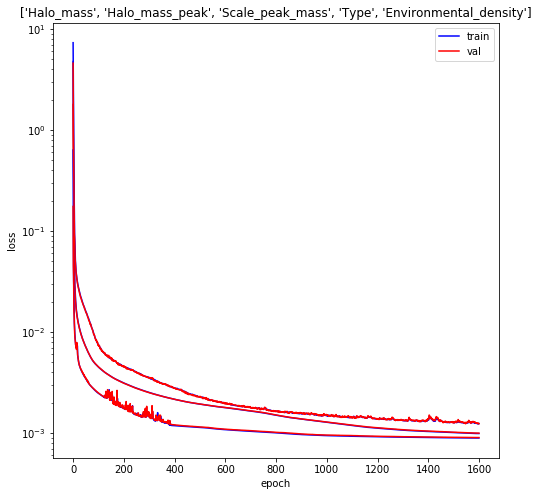

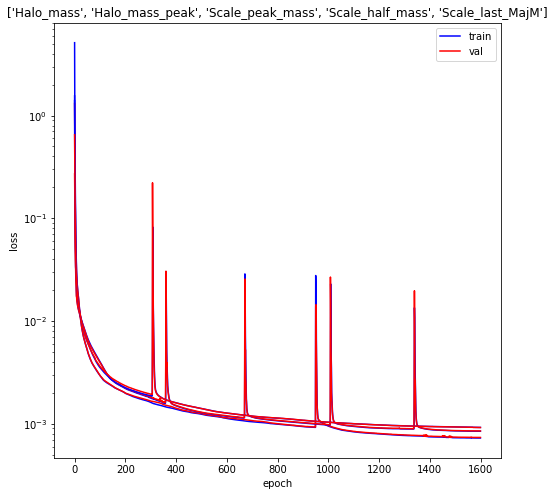

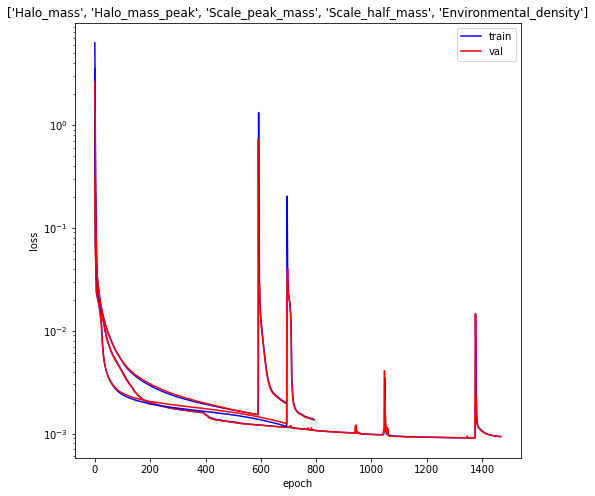

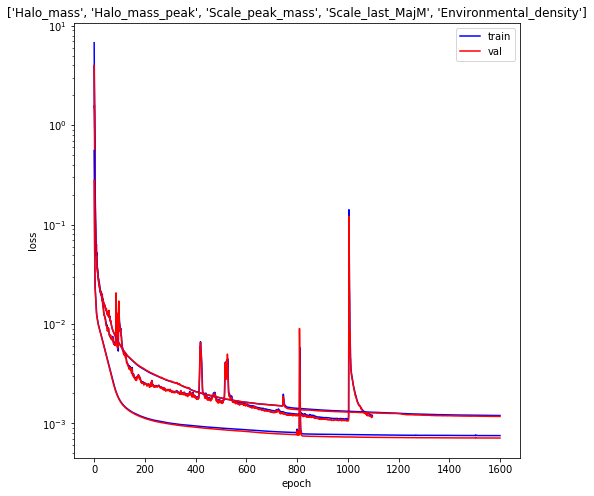

In [23]:
### Plot the loss histories to make sure that the best performance was reached

for comb_nr, lst in enumerate(results_list[1:]):

    title = lst[0]
    train_loss = lst[2][0][0]
    val_loss = lst[2][0][1]
    test_loss = lst[1][0]

    #print('Lowest train/val/test loss: %.2e, %.2e, %.2e' % (np.amin(train_loss), np.amin(val_loss), np.amin(test_loss)))

    # summarize history for loss
    fig = plt.figure(5, figsize=(8,8))
    for i_run in range(len(test_loss)):
        train_loss = lst[2][i_run][0]
        val_loss = lst[2][i_run][1]
        plt.plot(train_loss, 'b')
        plt.plot(val_loss, 'r')
    plt.yscale('log')
    plt.title(title)
    plt.ylabel('loss')
    plt.xlabel('epoch')
    plt.legend(['train', 'val'], loc='upper right')
    plt.show()


In [15]:
print(results_list[1][0])

['Halo_mass', 'Halo_mass_peak']


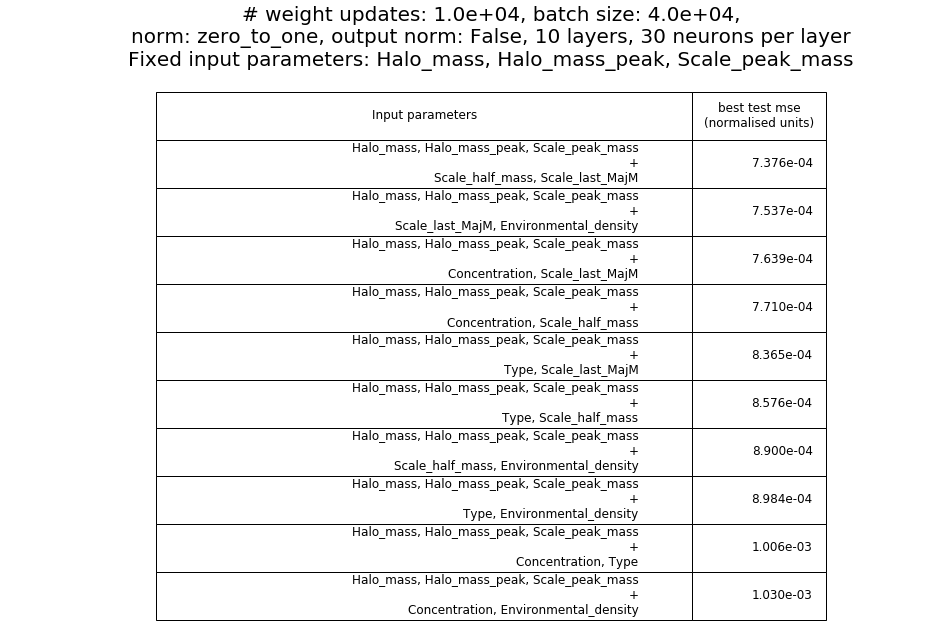

In [35]:
### Get the X best performing input parameters
get_normed_scores = 1
top_nr_of_parameter_combs = 10
column_widths = [0.2, 0.05]
test_results = []
val_results = []
for comb_nr, lst in enumerate(results_list[1:]):
    if get_normed_scores:
        best_test = np.amin(lst[1][0])
    else:
        best_test = np.amin(lst[1][1])
        
#    val_losses = []
#    for i_run in range(len(lst[1])):
#        val_losses.append(lst[2][i_run][1])
        
    test_results.append(best_test)
#    val_results.append(np.amin(val_losses))
    
best_test_indices = np.argsort(test_results)
#best_val_indices = np.argsort(val_results)

fig1362 = plt.figure(figsize=(16,8))

ax = plt.subplot(1,1,1)

collabel=('Input parameters', 'best test mse\n(normalised units)')
table_vals = []
for i in range(top_nr_of_parameter_combs):
    
    inputs = ', '.join(results_list[best_test_indices[i]+1][0][:3])
    inputs = inputs + '\n+\n' + ', '.join(results_list[best_test_indices[i]+1][0][3:])
    
    table_vals.append([inputs, '%.3e' % 
                      (np.amin(results_list[best_test_indices[i]+1][1]))])

the_table = ax.table(cellText=table_vals,colLabels=collabel,colWidths=column_widths,loc='center')
the_table.set_fontsize(15)
the_table.scale(3, 4)
ax.axis('tight')
ax.axis('off')
plt.title('# weight updates: %.1e, batch size: %.1e,\nnorm: %s, output norm: False, 10 layers, 30 neurons per layer' % 
          (results_list[0]['nr_steps'][0], results_list[0]['batch_size'][0], results_list[0]['data_normalization']) +
           '\nFixed input parameters: %s' % (', '.join(results_list[0]['fixed_input_features'])), 
          fontsize=20)
ttl = ax.title
ttl.set_position([0.5, 1.15])

plt.show()

In [36]:
fig1362.savefig(fig_dir + '5_total_inputs' + '_param_comb_scores_test.png', bbox_inches = 'tight')

In [8]:
### Plot best validation scores
fig2 = plt.figure(figsize=(16,8))


ax = plt.subplot(1,1,1)

collabel=('Input parameters', 'best val mse\n(scaled units)')
table_vals = []
for i in range(top_nr_of_parameter_combs):
    
    inputs = ', '.join(results_list[best_val_indices[i]+1][0])
    
    table_vals.append([inputs, '%.3f' % 
                      (val_results[best_val_indices[i]])])

the_table = ax.table(cellText=table_vals,colLabels=collabel,colWidths=column_widths,loc='center')
the_table.set_fontsize(15)
the_table.scale(3, 3)

plt.subplots_adjust(left=None, bottom=None, right=None, top=None,
                wspace=0.2, hspace=0.5)

ax.axis('tight')
ax.axis('off')
plt.title('# weight updates: %.1e, batch size: %.1e,\nnorm: %s, relu on output: False, 10 layers, 10 neurons per layer' % 
          (results_list[0]['nr_steps'][0], results_list[0]['batch_size'][0], results_list[0]['data_normalization'], 
          ), fontsize=20)
ttl = ax.title
ttl.set_position([0.5, 1])

#plt.tight_layout(h_pad=30)

plt.show()

ValueError: The truth value of an array with more than one element is ambiguous. Use a.any() or a.all()

In [ ]:
fig2.savefig(fig_dir + '2018-05-12--13-36-02_param_comb_scores_val.png', bbox_inches = 'tight')

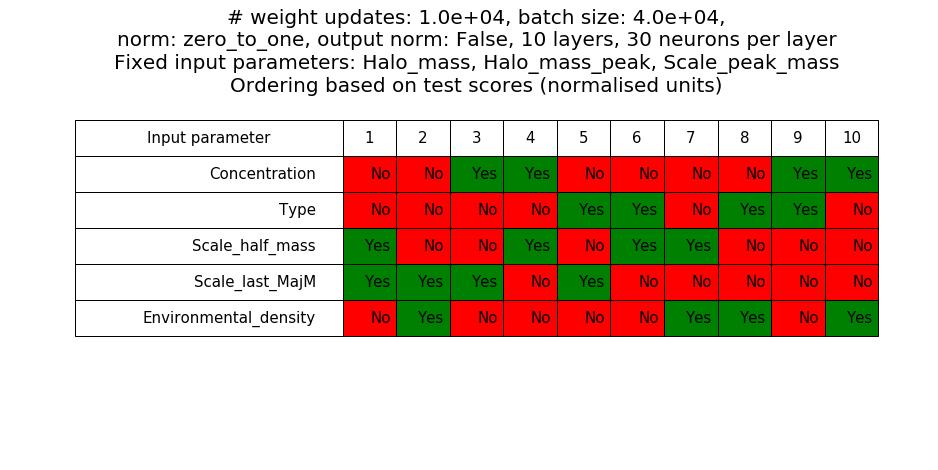

In [37]:
### Find out how a parameter affects the result
collabel = ('Input parameter', '1', '2', '3', '4', '5', '6', '7', '8', '9', '10')
first_col_width = .1
last_col_width = .02
column_widths = [first_col_width]
for i in range(10):
    column_widths.append(last_col_width)
tab_rows = []
row_colours = []

for param in results_list[0]['tested_input_features']:
    
    tab_row = [param]
    row_colour = ['w']

    for i, ind in enumerate(best_test_indices[:10]):
        inputs = results_list[ind+1][0]
        if param in inputs:
            tab_row.append('Yes')
            row_colour.append('g')
        else:
            tab_row.append('No')
            row_colour.append('r')

    tab_rows.append(tab_row)
    row_colours.append(row_colour)
        
fig8845 = plt.figure(figsize=(16,8))

ax = plt.subplot(111)

the_table = ax.table(cellText=tab_rows,colLabels=collabel,colWidths=column_widths,
                     cellColours=row_colours,loc='center')
the_table.set_fontsize(15)
the_table.scale(3, 3)

plt.subplots_adjust(left=None, bottom=None, right=None, top=None,
                wspace=0.2, hspace=0.5)
plt.title('# weight updates: %.1e, batch size: %.1e,\nnorm: %s, output norm: False, 10 layers, 30 neurons per layer'
          % (results_list[0]['nr_steps'][0], results_list[0]['batch_size'][0], results_list[0]['data_normalization'])+
           '\nFixed input parameters: %s\nOrdering based on test scores (normalised units)' % 
          (', '.join(results_list[0]['fixed_input_features'])), fontsize=20)
#plt.title('Ordering based on validation scores', fontsize=20)
ttl = ax.title
ttl.set_position([0.5, 0.8])

#ax.axis('tight')
ax.axis('off')

plt.show()
    

In [38]:
fig8845.savefig(fig_dir + '5_total_inputs' + '_param_importance_test.png', bbox_inches = 'tight')

## Plot loss history

In [ ]:
# list all data in history
print(history.history.keys())

In [ ]:
# summarize history for loss
%matplotlib inline
fig = plt.figure(5, figsize=(8,8))
plt.plot(train_loss, 'b')
plt.plot(val_loss, 'r')
plt.yscale('log')
plt.title(title)
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper right')
plt.show()

## Evaluate the model

In [ ]:
# On preprocessed data
test_loss, test_mse = model.evaluate(x_test_norm, y_test_norm, verbose=0)
print('MSE for the processed data: %.4f' % (test_mse))

In [50]:
### Predict real value of points
if norm == 'zero_mean_unit_std':
    predicted_norm_points = model.predict(training_data_dict['x_test_norm'])
    predicted_points = predicted_norm_points * training_data_dict['y_data_stds'] + training_data_dict['y_data_means']
    
if norm == 'zero_to_one':
    predicted_norm_points = model.predict(training_data_dict['x_test_norm'])
    predicted_points = predicted_norm_points * (training_data_dict['y_data_max'] - training_data_dict['y_data_min']) + \
                        training_data_dict['y_data_min']

In [ ]:
### Get mse for the real predictions
n_points = np.shape(predicted_points)[0]
x_minus_y = predicted_points - y_test

feature_scores = np.sum(np.power(x_minus_y, 2), 0) / n_points
total_score = np.sum(feature_scores) / 2

print('MSE for the unprocessed data: %.4f' % (total_score))

## Save a model

In [ ]:
### Save the model if it is useful
importlib.reload(model_management)
model_dictionary = {
    'training_method': 'backprop',
    'input_features': input_features,
    'output_features': output_features,
    'number_of_epochs': nEpochs,
    'batch_size': batchSize,
    'number_of_layers': nLayers,
    'neurons_per_layer': neuronsPerLayer,
    'activation_function': activationFunction,
    'train_set_size': train_size,
    'loss_function': loss_function,
    'test_loss': test_loss,
    'test_mse': test_mse,
    'preprocess_data': preprocess_data
}
description = 'First network trained on preprocessed data.'
model_management.SaveModel(model, model_dictionary, description)

In [ ]:
%matplotlib notebook
#x1 = np.linspace(np.min(x_test[:,0]), np.max(x_test[:,0]), 30)
#x2 = np.linspace(np.min(x_test[:,1]), np.max(x_test[:,1]), 30)
#X1, X2 = np.meshgrid(x1, x2)
#Z = np.zeros(X1.shape)
#for i in range(30):
#    for j in range(30):
#        Z[i, j] = model.predict(np.array([X1[i,j], X2[i,j]])) TODO varför funkar inte det här??
        
#fig = plt.figure(4)
#ax = plt.axes(projection='3d')
#ax.contour3D(X, Y, Z, 50, cmap='binary')
#ax.set_xlabel('x')
#ax.set_ylabel('y')
#ax.set_zlabel('z')
        
### Old visualisation way
### Visualisation of prediction strength for when we have 2 input features
if plot_threeD and len(input_features) == 2:
    predictedY = model.predict(x_test_norm)
    predictedY = predictedY * y_data_stds + y_data_means
    fig = plt.figure(2, figsize=(8,8))
    ax = fig.add_subplot(111, projection='3d')
    ax.scatter(x_test[:,0], x_test[:,1], 
               y_test[:,0], s=3)
    ax.scatter(x_test[:,0], x_test[:,1], 
               predictedY, s=3)
    ax.set_xlabel('%s log($M_{H}/M_{S}$)' % (input_features[0]))
    ax.set_ylabel('%s log($M_{H}/M_{S}$)' % (input_features[1]))
    ax.set_zlabel('%s log($M_{G}/M_{S}$)' % (output_features[0]))

## Scatterplots and boxplots

In [ ]:
%matplotlib inline
#from pylab import plot, show, savefig, xlim, figure, \
#                hold, ylim, legend, boxplot, setp, axes
nBins = 8
halo_min_mass = np.amin(galaxies[:,6])
halo_max_mass = np.amax(galaxies[:,6])
bin_edges = np.linspace(halo_min_mass, halo_max_mass, nBins+1)

x_test = training_data_dict['x_test']
y_test = training_data_dict['y_test']

predictedY = predicted_points

for i, feat in enumerate(output_features):
    
    ### Plot 1
    fig1 = plt.figure(figsize=(8,8))
    
    plt.plot(y_test[:,i], y_test[:,i], 'k.')
    plt.plot(predictedY[:,i], y_test[:,i], 'g.')
    plt.ylabel('True %s %s' % (feat, unit_dict[feat]), fontsize=15)
    plt.xlabel('Predicted %s %s' % (feat, unit_dict[feat]), fontsize=15)
    plt.legend(['Ideal result', 'predicted ' + feat], loc='upper center')
    #plt.title('nEpochs: %d, batch size: %d, training set size: %d, test mse score: %.2e\n' % (nEpochs, 
    #    batchSize, train_size, test_mse) + 
    #    '%d input feature(s): [%s]\n%d output feature(s): [%s]\n%d test data points (test) shown' % (
    #    len(input_features), ', '.join(input_features), len(output_features), ', '.join(output_features),
    #    test_size), y=1.03, fontsize=20)
    plt.show
    
    ### Plot 2 - boxplot
    
    # bin_means contain (0: mean of the binned values, 1: bin edges, 2: numbers pointing each example to a bin)
    bin_means_true = stats.binned_statistic(x_test[:,i], y_test[:,i], bins=bin_edges)
    bin_means_pred = stats.binned_statistic(x_test[:,i], predictedY[:,i].flatten(), bins=bin_edges)
    bin_centers = []
    for iBin in range(nBins):
        bin_center = (bin_means_true[1][iBin] + bin_means_true[1][iBin+1]) / 2
        bin_centers.append('%.2f' % (bin_center))
    sorted_true_y_data = []
    sorted_pred_y_data = []
    for iBin in range(1,nBins+1):
        sorted_true_y_data.append(y_test[bin_means_true[2] == iBin, i])
        sorted_pred_y_data.append(predictedY[bin_means_pred[2] == iBin,i])
        
    fig2 = plt.figure(figsize=(16,8))
    ax = plt.subplot(111)

    bin_pos = np.array([-2,-1]) # (because this makes it work)
    x_label_centers = []
    for iBin in range(nBins):
        # Every boxplot adds 2 boxes, one from the true data and one from the predicted data
        bin_pos += 3 
        plt.boxplot([sorted_true_y_data[iBin], sorted_pred_y_data[iBin]] , positions = bin_pos, widths = 0.9)
        x_label_centers.append(np.mean(bin_pos))
    
    plt.ylabel('%s %s' % (feat, unit_dict[feat]), fontsize=15)
    plt.xlabel('True Halo mass log($M_{G}/M_{S}$)', fontsize=15)
    ax.set_xlim(left=x_label_centers[0]-2, right=x_label_centers[-1]+2)
    #xlim(0,bin_pos[1] + 1)
    plt.xticks(x_label_centers, bin_centers)
    #plt.text(12,7,'Left: true data. Right: predicted data.', fontsize=20)
    
    if feat == 'SFR':
        ax.axhline(y=0, linestyle='--')
    
    #plt.title('nEpochs: %d, batch size: %d, training set size: %d, test mse score: %.2e\n' % (nEpochs, 
    #    batchSize, train_size, test_mse) + 
    #    '%d input feature(s): [%s]\n%d output feature(s): [%s]\n%d test data points (test) shown' % (
    #    len(input_features), ', '.join(input_features), len(output_features), ', '.join(output_features),
    #    test_size), y=1.03, fontsize=20)
    
    plt.show()        

In [ ]:
fig1.savefig(fig_dir+'bp_output_scatter_%d_plot_from_' % (i+1)+'_and_'.join(input_features)+'_to_'+
            '_and_'.join(output_features)+'_with_'+param_string+'.png', bbox_inches = 'tight')
fig2.savefig(fig_dir+'bp_output_boxplot_%d_from_' % (i+1)+'_and_'.join(input_features)+'_to_'+
            '_and_'.join(output_features)+'_with_'+param_string+'.png', bbox_inches = 'tight')

## Scatterplots and plots with errorbars

In [51]:
### Predict real value of points
if norm == 'zero_mean_unit_std':
    predicted_norm_points = model.predict(training_data_dict['x_test_norm'])
    predicted_points = predicted_norm_points * training_data_dict['y_data_stds'] + training_data_dict['y_data_means']
    
if norm == 'zero_to_one':
    predicted_norm_points = model.predict(training_data_dict['x_test_norm'])
    predicted_points = predicted_norm_points * (training_data_dict['y_data_max'] - training_data_dict['y_data_min']) + \
                        training_data_dict['y_data_min']

/opt/anaconda/lib/python3.6/site-packages/numpy/core/_methods.py:135: RuntimeWarning: Degrees of freedom <= 0 for slice
  keepdims=keepdims)
/opt/anaconda/lib/python3.6/site-packages/numpy/core/_methods.py:105: RuntimeWarning: invalid value encountered in true_divide
  arrmean, rcount, out=arrmean, casting='unsafe', subok=False)
/opt/anaconda/lib/python3.6/site-packages/numpy/core/_methods.py:127: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


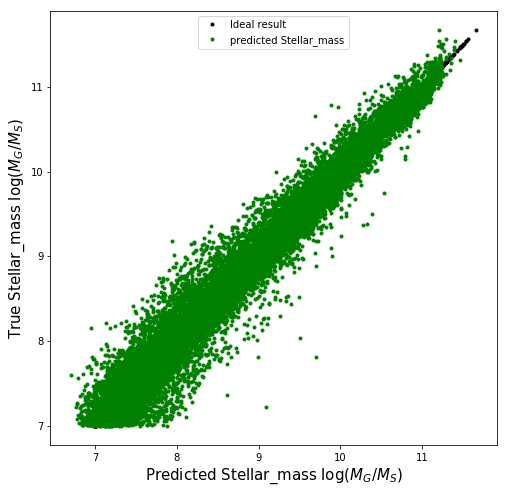

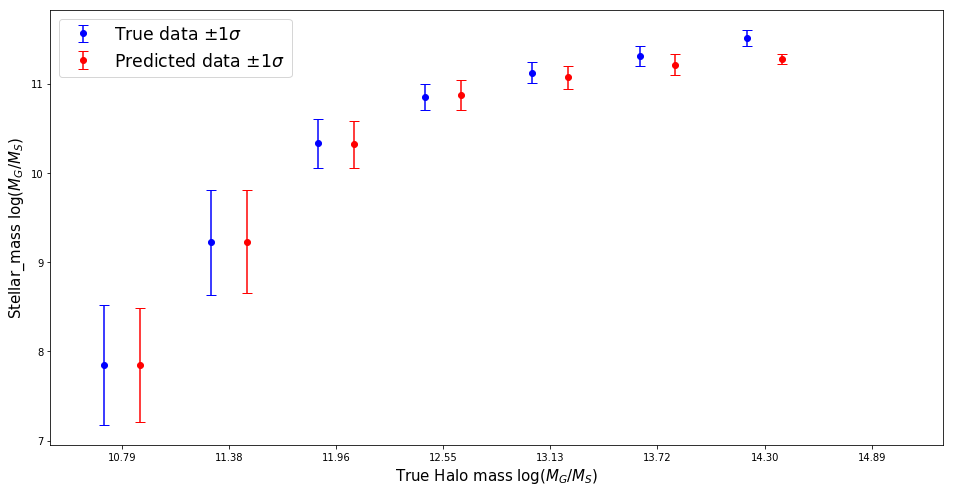

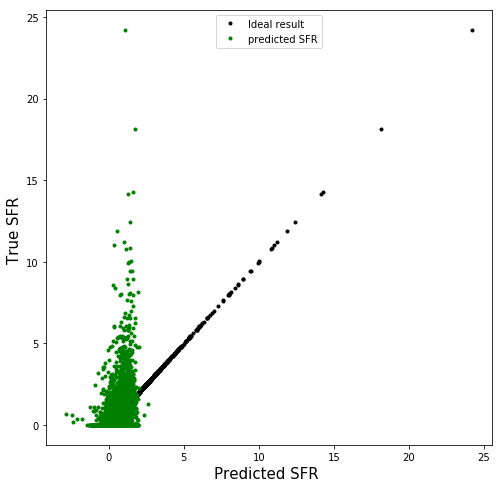

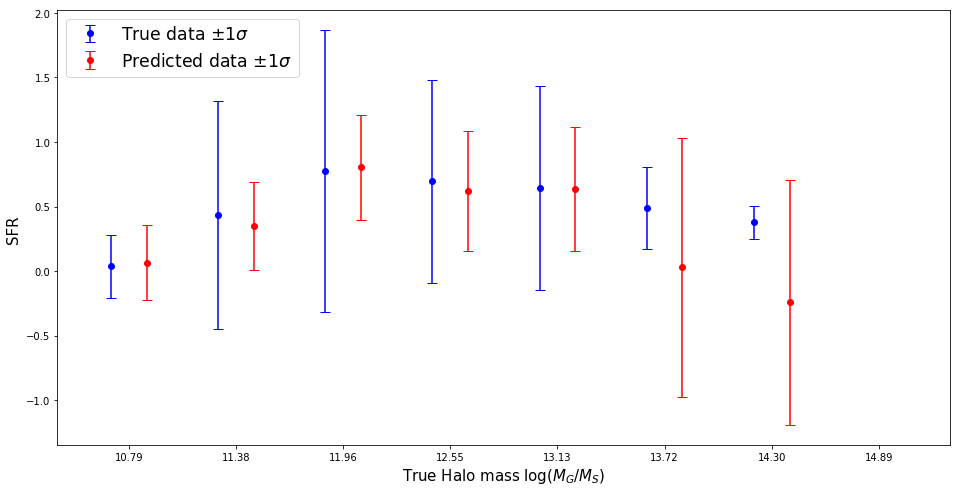

In [52]:
%matplotlib inline
#from pylab import plot, show, savefig, xlim, figure, \
#                hold, ylim, legend, boxplot, setp, axes
nBins = 8
halo_min_mass = np.amin(galaxies[:,6])
halo_max_mass = np.amax(galaxies[:,6])
bin_edges = np.linspace(halo_min_mass, halo_max_mass, nBins+1)

x_test = training_data_dict['x_test']
y_test = training_data_dict['y_test']

predictedY = predicted_points

for i, feat in enumerate(output_features):
    
    
    ### Plot 1
    fig1 = plt.figure(figsize=(8,8))
    
    plt.plot(y_test[:,i], y_test[:,i], 'k.')
    plt.plot(predictedY[:,i], y_test[:,i], 'g.')
    plt.ylabel('True %s %s' % (feat, unit_dict[feat]), fontsize=15)
    plt.xlabel('Predicted %s %s' % (feat, unit_dict[feat]), fontsize=15)
    plt.legend(['Ideal result', 'predicted ' + feat], loc='upper center')
    #plt.title('nEpochs: %d, batch size: %d, training set size: %d, test mse score: %.2e\n' % (nEpochs, 
    #    batchSize, train_size, test_mse) + 'loss function: %s\n' % (loss_function) +
    #    '%d input feature(s): [%s]\n%d output feature(s): [%s]\n%d data points (test) shown' % (
    #    len(input_features), ', '.join(input_features), len(output_features), ', '.join(output_features),
    #    test_size), y=1.03, fontsize=20)
    plt.show
    
    ### Plot 2 - Spread of the distribution
    
    # bin_means contain (0: mean of the binned values, 1: bin edges, 2: numbers pointing each example to a bin)
    bin_means_true = stats.binned_statistic(x_test[:,0], y_test[:,i], bins=bin_edges)
    bin_means_pred = stats.binned_statistic(x_test[:,0], predictedY[:,i].flatten(), bins=bin_edges)

    bin_centers = []
    for iBin in range(nBins):
        bin_center = (bin_means_true[1][iBin] + bin_means_true[1][iBin+1]) / 2
        bin_centers.append('%.2f' % (bin_center))
    sorted_true_y_data = []
    sorted_pred_y_data = []
    for iBin in range(1,nBins+1):
        sorted_true_y_data.append(y_test[bin_means_true[2] == iBin, i])
        sorted_pred_y_data.append(predictedY[bin_means_pred[2] == iBin,i])
    
    # get standard deviations of the binned values
    stds_true = np.zeros((nBins))
    stds_pred = np.zeros((nBins))
    for iBin in range(nBins):
        stds_true[iBin] = np.std(sorted_true_y_data[iBin])
        stds_pred[iBin] = np.std(sorted_pred_y_data[iBin])
        
    fig2 = plt.figure(figsize=(16,8))
    ax = plt.subplot(111)

    bin_pos = np.array([-2,-1]) # (because this makes it work)
    x_label_centers = []
    for iBin in range(nBins):
        # Every plot adds 2 distributions, one from the true data and one from the predicted data
        bin_pos += 3 
        plt.errorbar(bin_pos[0], bin_means_true[0][iBin], yerr=stds_true[iBin], fmt = 'bo', capsize=5)
        plt.errorbar(bin_pos[1], bin_means_pred[0][iBin], yerr=stds_pred[iBin], fmt = 'ro', capsize=5)
        x_label_centers.append(np.mean(bin_pos))
    
    plt.ylabel('%s %s' % (feat, unit_dict[feat]), fontsize=15)
    plt.xlabel('True Halo mass log($M_{G}/M_{S}$)', fontsize=15)
    plt.legend(['True data $\pm 1 \sigma$', 'Predicted data $\pm 1 \sigma$'], loc='upper left', fontsize='xx-large')
    ax.set_xlim(left=x_label_centers[0]-2, right=x_label_centers[-1]+2)
    #xlim(0,bin_pos[1] + 1)
    plt.xticks(x_label_centers, bin_centers)
    
    #plt.title('nEpochs: %d, batch size: %d, training set size: %d, test mse score: %.2e\n' % (nEpochs, 
    #    batchSize, train_size, test_mse) + 'loss function: %s\n' % (loss_function) +
    #    '%d input feature(s): [%s]\n%d output feature(s): [%s]\n%d data points (test) shown' % (
    #    len(input_features), ', '.join(input_features), len(output_features), ', '.join(output_features),
    #    test_size), y=1.03, fontsize=20)
    
    plt.show()

In [ ]:
fig1.savefig(fig_dir+'bp_output_scatter_%d_plot_from_' % (i+1)+'_and_'.join(input_features)+'_to_'+
            '_and_'.join(output_features)+'_with_'+param_string+'.png', bbox_inches = 'tight')
fig2.savefig(fig_dir+'bp_output_boxplot_%d_from_' % (i+1)+'_and_'.join(input_features)+'_to_'+
            '_and_'.join(output_features)+'_with_'+param_string+'.png', bbox_inches = 'tight')

In [ ]:
#print(predictedY.flatten())
#bin_means = stats.binned_statistic(predictedY.flatten(), y_test[:,0], bins=10)
#bin_stds = stats.binned_statistic(predictedY.flatten(), y_test[:,0], bins=10, statistic=GetSTD)
#print(bin_means[0])
#print(bin_stds[0])

## Plot SFR vs Stellar mass

In [ ]:
### Predict real value of points
if norm == 'zero_mean_unit_std':
    predicted_norm_points = model.predict(training_data_dict['x_test_norm'])
    predicted_points = predicted_norm_points * training_data_dict['y_data_stds'] + training_data_dict['y_data_means']
    
if norm == 'zero_to_one':
    predicted_norm_points = model.predict(training_data_dict['x_test_norm'])
    predicted_points = predicted_norm_points * (training_data_dict['y_data_max'] - training_data_dict['y_data_min']) + \
                        training_data_dict['y_data_min']

In [ ]:
predictedY = predicted_points

fig = plt.figure(figsize=(12,8))
ax = plt.subplot(121)

plt.plot(predictedY[:,0], predictedY[:,1], 'b.', markersize=2)
plt.ylabel('Predicted SFR %s' % (unit_dict['SFR']), fontsize=15)
plt.xlabel('Predicted Stellar Mass %s' % (unit_dict['Stellar_mass']), fontsize=15)
ymin, ymax = ax.get_ylim()
ax.set_ylim(bottom=ymin, top=ymax)

ax = plt.subplot(122)
plt.plot(y_test[:,0], y_test[:,1], 'k.', markersize=2)
plt.ylabel('True SFR %s' % (unit_dict['SFR']), fontsize=15)
plt.xlabel('True Stellar Mass %s' % (unit_dict['Stellar_mass']), fontsize=15)
ax.set_ylim(bottom=ymin, top=ymax)
#plt.suptitle('nEpochs: %d, batch size: %d, training set size: %d, test mse score: %.2e\n' % (nEpochs, 
#    batchSize, train_size, total_score) + 'loss function: %s\n' % (loss_function) +
#    '%d input feature(s): [%s]\n%d output feature(s): [%s]\n%d data points (test) shown' % (
#    len(input_features), ', '.join(input_features), len(output_features), ', '.join(output_features),
#    test_size), y=1.17, fontsize=20)
plt.tight_layout()
plt.show

In [ ]:
### Save the figure
fig.savefig(fig_dir+'bp_sfr_to_stellar_mass_inputs_' + '_and_'.join(input_features)+
            '_with_'+param_string+'.png', bbox_inches = 'tight')

### Check to see how the MSE is calculated 

In [ ]:
predicted_points = model.predict(x_test)
print(np.shape(predicted_points))
n_points = np.shape(predicted_points)[0]
x_minus_y = predicted_points - y_test

feature_scores = np.sum(np.power(x_minus_y, 2), 0) / n_points
total_score = np.sum(feature_scores) / 2

print(total_score)

keras_scores = model.evaluate(x_test, y_test, verbose=0)
print(keras_scores)

In [ ]:
# summarize history for loss
%matplotlib inline
fig = plt.figure(5, figsize=(8,8))
plt.plot(history.history['loss'], 'b')
plt.plot(history.history['val_loss'], 'r')
plt.yscale('log')
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper right')
plt.show()

## Testing functions

In [ ]:
### TESTING
coordinates = galaxies[:1000, :3]
halo_masses = np.power(10, galaxies[:1000, 6])
nr_points = np.shape(coordinates)[0]

nr_neighbours_wanted = 30
box_sides = np.array([200, 200, 200])

neigh_densities = get_density_periodic(coordinates, halo_masses, nr_neighbours_wanted, 
                                                                 box_sides, nr_points, verbatim=True)
print(neigh_densities)